In [41]:
# Project specific modules
from src.pipeline import CleanYelpData

# The basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Spark library and functions
import pyspark as ps
import pyspark.sql.types as types
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import to_timestamp

# Sklearn Modeling
from sklearn.model_selection import train_test_split


# Surprise modeling
from surprise import SVD
import surprise
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Persistance
import pickle

# Housekeeping
from io import StringIO

# Spark Based Initial EDA

In [ ]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )
# sc = spark.sparkContext

review_df = spark.read.json("data/review.json")
# checkin_df = spark.read.json("data/checkin.json")
# tip_df = spark.read.json("data/tip.json")
# user_df = spark.read.json("data/user.json")
business_df = spark.read.json("data/business.json")

In [12]:
# Count of distinct values for all fields in review_df:
this = business_df.agg(*(countDistinct(col(c)).alias(c) for c in business_df.columns))
this.show(1)

+-------+----------+-----------+----------+----+-----+-------+--------+---------+------+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|  name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+------+-----------+------------+-----+-----+
| 151977|     67875|     192609|     93385|1204|51566|      2|  155162|   150404|145046|      17541|        1184|    9|   36|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+------+-----------+------------+-----+-----+



In [14]:
this = review_df.agg(*(countDistinct(col(c)).alias(c) for c in review_df.columns))
this.show(1)

+-----------+----+-------+-----+---------+-----+-------+------+-------+
|business_id|cool|   date|funny|review_id|stars|   text|useful|user_id|
+-----------+----+-------+-----+---------+-----+-------+------+-------+
|     192606| 201|6552820|  231|  6685900|    5|6668738|   289|1637138|
+-----------+----+-------+-----+---------+-----+-------+------+-------+



In [ ]:
bsubset_df = business_df.filter((business_df.categories.like('%Restaurants%')) &
                                (business_df.state == 'AZ')                               
                               )
print('There are {} Arizona restaurants in the dataset.'.format(bsubset_df.count()))

### Which region should we select for proceeding with this study? 

Let's look at the densities to decide:

In [ ]:
def calculate_region_density(state, businesses, bus_reviews):
    num_businesses = businesses.filter((businesses.categories.like('%Restaurants%')) &
                                (business_df.state == state)).count()
    num_reviews = bus_reviews.filter((bus_reviews.categories.like('%Restaurants%')) &
                                (bus_reviews.state == state)).count()
    return num_reviews/num_businesses

def compare_region_densities(regions, businesses, bus_reviews):
    max_density = 0
    density_dict = {}
    for region in regions:
        density = calculate_region_density(region, businesses, bus_reviews)
        density_dict[region] = density
        if density > max_density:
            max_density = density
            max_region = region

    print('Best Region: {}\nBest Density: {}'.format(max_region, max_density))
    return density_dict

In [ ]:
regions = ['AZ', 'ON', 'NC', 'AB', 'NV', 'OH', 'PA', 'IL', 'SC', 'QC']

density_dict = compare_region_densities(regions, business_df, bus_review_df)

pd.DataFrame.from_dict(density_dict, orient = 'index').sort_values(0, ascending = False).plot.bar(legend = False, figsize = (10, 6))
plt.ylabel('Review Density')
plt.xlabel('Region')
plt.title('Review Density by Region')

## Major Metros in Dataset
#### Las Vegas
* Henderson
#### Toronto
* Missassauga
* Markham
* North York
#### Phoenix - 56,686
* Mesa
* Tempe
* Scottsdale
* Chandler
* Glendale
* Gilbert
* Peoria
* Surprise
#### Calgary
#### Pittsburgh
#### Montreal
#### Cleveland
#### Madison, WI
#### Champaign, IL

## The winner: Arizona

We are proceeding with Arizona based businesses for this case study. Although Nevada has a greater density of reviews/restaurant, this data scientist considers it to be an anomaly in the restaurant space as well as user space given the impact tourism would have on restaurant visits/reviews. Arizona has the next highest density, would be expected to include a healthy mix of resident and non-resident reviews, most reviews are concentrated around Phoenix, and we would expect Phoenix to have a diverse group of users.

# Further EDA

Let's go ahead and pare the data down to reviews for restaurants in our area of interest so we can work in Pandas. To deal with the issue of running out of memory loading the entire dataset, the code below uses a project-specific class to read the data in chunks, identify the rows of interest, and then join the pertinent parts of all chunks together.

In [ ]:
# Load the data without spark but still accounting for low memory
pipe = CleanYelpData(use_spark=False, low_memory = True)
pipe.read_data()
bus_review_df = pipe.concatenate_chunks()

Alternatively, we can just load the data from a file created by the above process

In [147]:
bus_review_df = pd.read_pickle('data/bus_review_df.pkl')

### Let's dive deeper into the data. What is the distribution of users per restaurant? 

Keeping in mind this is log-scaled on the y axis, this data appears to be exponentially distributed.

Text(0, 0.5, 'Number of Restaurants (Log-scaled)')

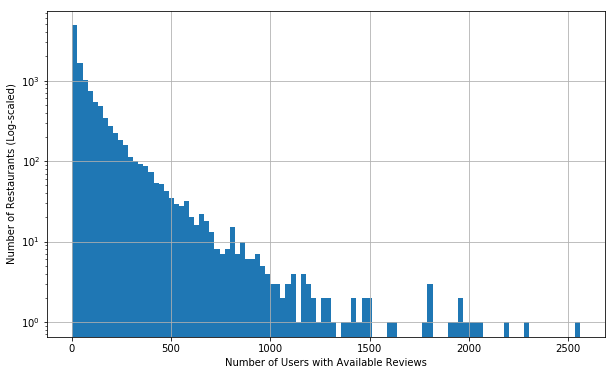

In [277]:
groups = bus_review_df.groupby('business_id')
ax = groups.user_id.nunique().hist(bins = 100, figsize = (10, 6))
ax.set_yscale('log')
ax.set_xlabel('Number of Users with Available Reviews')
ax.set_ylabel('Number of Restaurants (Log-scaled)')
# The number of users who reviewed each restaurant restaurant is exponentially distributed throughout
# the restaurants in AZ.

What is the distribution of ratings per user?

From the graph below, we are able to see that this is exponentially distributed. There are several users who have made significant numbers of reviews. Normally this might be cause for concern that their reviews are not legitimate; however, this dataset consists only of reviews that Yelp has validated and "recommended", so they are likely just very passionate about food.

Text(0, 0.5, 'Number of Users (Log-scaled)')

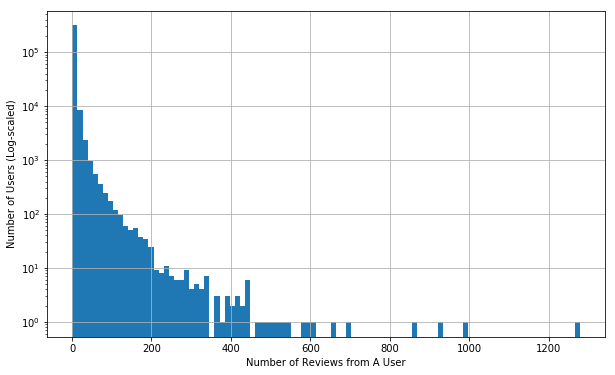

In [296]:
groups = bus_review_df.groupby('user_id')
ax = groups.review_id.nunique().hist(bins = 100, figsize = (10, 6))
ax.set_yscale('log')
ax.set_xlabel('Number of Reviews from A User')
ax.set_ylabel('Number of Users (Log-scaled)')

Let's verify the text of the highest volume user to be sure they are not a bot. As shown below, only one user exceeded 1000 reviews and their id is 'ELcQDlf69kb-ihJfxZyL0A'.

In [265]:
groups = bus_review_df.groupby('user_id')
groups.review_id.nunique()[groups.review_id.nunique()>1000]

user_id
ELcQDlf69kb-ihJfxZyL0A    1278
Name: review_id, dtype: int64

As we see below, they appear to be legitimate. We may be curious as to why someone would write so many reviews, but that is outside the scope of this project.

In [272]:
bus_review_df[bus_review_df.user_id == 'ELcQDlf69kb-ihJfxZyL0A'].text.iloc[356]

'If you dine-in, you will likely be annoyed by some screaming kid and their mommy, but if you can ignore that noise for about ten minutes, you will be rewarded with a delicious waffle experience. I simply had the churro waffle and got my free YELP topping of bananas. The cinnamon sugar waffle was loaded with cinnamon cream and fruit. It was a chewy waffle and stayed hot the entire visit. You will need both knife and fork, but every bite was very tasty and unique as well. All totaled, it was just over 5 bucks, so a good value and fairly filling breakfast.'

In [273]:
bus_review_df[bus_review_df.user_id == 'ELcQDlf69kb-ihJfxZyL0A'].text.iloc[763]

'Not too impressed with the prices or quality of this semi new ice cream place. The lone asian women behind the counter was nice, but this shop immediately reminded me of one of those asian donut shops you see in every city. The donuts in those places are not usually good and the ice cream here was less than memorable as well. First off, make the size of the sundae bigger or lower the $6.50 price of that sundae. It\'s not even a sundae technically because it has no syrup. You get two small scoops of bad ice cream (i needed to try 5 flavors to find decent one), two stale macaroons and that "famous" toasted marshmallow. One person with me had a bad aftertaste for at least an hour after the nutella. My flavor was cinnamon toast crunch, which like many flavors, are just vanilla with cereal tossed inside. If your gonna overpay for ice cream, go to creamistry. BTW , If you go non sundae, prices are normal.'

### Although we have seen some serious outliers on the high volume end, given that we believe these to be genuine reviews, we are going to graciously accept their contributions to our density.

### Let's continue to quantify some more metrics about our data: 

What is the average number of unique users who reviewed each restaurant?

In [289]:
groups = bus_review_df.groupby('business_id')
mean = groups.user_id.nunique().mean()
print('On average, each restaurant has been reviewed by {:.2f} users.'.format(mean))

On average, each restaurant has been reviewed by 100.11 users.


What about for reviews?

In [288]:
groups = bus_review_df.groupby('business_id')
mean = groups.review_id.nunique().mean()
print('The average number of reviews per restaurant is {:.2f}'.format(mean))

The average number of reviews per restaurant is 103.94


The fact that the average number for reviews is higher than that of users demonstrates that there are cases where the same users have left multiple reviews for the same restaurant.

In [303]:
groups = bus_review_df.groupby('business_id')
user_threshold = 10
num_restaurants = len(groups.groups)
rest_over_10_users = groups.user_id.nunique()[groups.user_id.nunique()>=user_threshold].count()

print('There are {} restaurants with {} or more reviews.'.format(rest_over_10_users, user_threshold))
print('This makes up {:.1f}% of the total restaurants in our scope.'.format(100*rest_over_10_users/num_restaurants))

# Out of 11,465 restaurants in AZ
# 3345 have been reviewed by 100 or more users (not nearly enough)
# 7610 have been reviewed by 20 or more users (close but could be better)
# 9293 have been reviewed by 10 or more users (81% of restaurants, this works)

There are 9293 restaurants with 10 or more reviews.
This makes up 81.1% of the total restaurants in our scope.


## For model training, let's consider trimming down our dataset

We have done some preliminary modeling with rough results (essentially the same as taking the average). It is expected that the restaurants and users with low counts of reviews are making our user-restaurant matrix too sparse. Let's cut off those density killers and re-evaluate some of these metrics.

In [413]:
user_thresholds = [2, 3, 4, 5, 6, 7]

for thresh in user_thresholds:
    groups = bus_review_df.groupby('user_id')
    user_selection = groups.review_id.nunique()>=thresh
    user_selection = user_selection[user_selection]
    trimmed_df = bus_review_df[bus_review_df.user_id.isin(user_selection.index)]

    full = len(bus_review_df)
    trimmed = len(trimmed_df)
    print('Removing users with less than {} reviews leaves us with {:.2f}% of the original amount of reviews.'.format(thresh, 100*(trimmed)/full))

Removing users with less than 2 reviews leaves us with 85.38% of the original amount of reviews.
Removing users with less than 3 reviews leaves us with 76.13% of the original amount of reviews.
Removing users with less than 4 reviews leaves us with 69.32% of the original amount of reviews.
Removing users with less than 5 reviews leaves us with 63.92% of the original amount of reviews.
Removing users with less than 6 reviews leaves us with 59.53% of the original amount of reviews.
Removing users with less than 7 reviews leaves us with 55.79% of the original amount of reviews.


In [414]:
business_thresholds = [5, 10, 20, 30, 40, 50]

for thresh in business_thresholds:
    groups = bus_review_df.groupby('business_id')
    business_selection = groups.user_id.nunique()>=thresh
    business_selection = business_selection[business_selection]
    trimmed_df = bus_review_df[bus_review_df.business_id.isin(business_selection.index)]

    full = len(bus_review_df)
    trimmed = len(trimmed_df)
    print('Removing businesses reviewed by less than {} users leaves us with {:.2f}% of the original amount of reviews.'.format(thresh, 100*(trimmed)/full))

Removing businesses reviewed by less than 5 users leaves us with 99.75% of the original amount of reviews.
Removing businesses reviewed by less than 10 users leaves us with 98.95% of the original amount of reviews.
Removing businesses reviewed by less than 20 users leaves us with 96.90% of the original amount of reviews.
Removing businesses reviewed by less than 30 users leaves us with 94.58% of the original amount of reviews.
Removing businesses reviewed by less than 40 users leaves us with 92.45% of the original amount of reviews.
Removing businesses reviewed by less than 50 users leaves us with 90.23% of the original amount of reviews.


### Based on these results, we are selecting based on the following:
* Only including reviews for businesses that have been reviewed by at least 50 users
* Only including reviews for users that have reviewed at least 4 restaurants

In [420]:
# Time to trim the data set based on minimum thresholds as defined above
groups = bus_review_df.groupby('user_id')
user_selection = groups.review_id.nunique()>=4
user_selection = user_selection[user_selection]
trimmed_df = bus_review_df[bus_review_df.user_id.isin(user_selection.index)]

groups = trimmed_df.groupby('business_id')
business_selection = groups.user_id.nunique()>=50
business_selection = business_selection[business_selection]
trimmed_df = trimmed_df[trimmed_df.business_id.isin(business_selection.index)]

In [ ]:
# And let's pickle it for testing models in our module on AWS
trimmed_df.to_json('data/trimmed_df.json', orient = 'records')

## Setting threshold to accept only restaurants reviewed by 10 or more users. So how many total users does that leave us with?

In [ ]:
# What time frame do these do these reviews span?

In [ ]:
# What about multiple reviews by one user? We should only take the latest...

In [ ]:
# Are there multiple reviews per user-restaurant?

In [244]:
def calculate_density(df, numerator, denominator):
    '''
    Calculate density of one column to the other
    
    Params:
    ~~~~~~~~~
    df: type - Pandas Dataframe
    the dataframe holding the data from which you want to calculate the density
    numerator: type - string
    the name of the column that you want to find the density
    of with respect to some other column
    denominator: type - string
    the name of the column over which you want to calculate the density
    
    Example:
    # The density of users to businesses:
    calculate_density(df, df.user_id, df.business_id)
    '''
    num = len(df.groupby(numerator))
    den = len(df.groupby(denominator))
    return num/den

calculate_density(bus_review_df, 'user_id', 'business_id')


28.334321849105976

# Explore modeling

In [6]:
# sample_df = pd.read_json('data/review_sample.json', lines = True)

In [62]:
# sample_df = pd.read_json('data/review_sample.json', lines = True)
# sample_df.drop(columns = ['cool', 'date', 'review_id',
#                         'funny', 'text', 'useful'], inplace = True)

In [144]:
# bus_review_df.drop(columns = ['cool', 'date', 'review_id',
#                         'funny', 'text', 'useful'], inplace = True)

In [77]:
pd.factorize(bus_review_df.business_id)[0]

array([   0,    0,    0, ..., 4101, 4101, 4101])

In [73]:
df = bus_review_df[['user_id', 'business_id', 'review_stars']]

y = df['review_stars']
X = df.drop('review_stars', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

identifier_df_train = X_train[['user_id', 'business_id']]
identifier_df_test = X_test[['user_id', 'business_id']]

In [74]:
# A reader is needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df, reader)

all_predictions = []
all_ratings = []

algs = [SVD(), surprise.SlopeOne(), surprise.NMF(),
                  surprise.NormalPredictor(), surprise.KNNBaseline(),
                  # surprise.KNNBasic(), surprise.KNNWithMeans(),
                  # surprise.KNNWithZScore(), surprise.BaselineOnly(),
                  surprise.CoClustering()]

# Iterate over all algorithms
for algorithm in algs:
    
    # Take a look at cross validation results to compare model types
    cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

    
#     # fit the model
#     alg_name = str(algorithm)[str(algorithm).find('ization')+8 : str(algorithm).find('obj')-1]
#     print('Fitting algorithm {}'.format(alg_name))
#     algorithm.fit(train_set)

#     # run predictions over
#     print('Predicting algorithm {}'.format(alg_name))
#     model_predictions = []
#     model_ratings = []
#     for idx, row in X_test.iterrows():
#         prediction = algorithm.predict(row[0], row[1])
#         model_predictions.append(prediction)
#         model_ratings.append(prediction[3])

#     # Pickle the models
#     pred_pkl_file = alg_name + '_predictions.pkl'
#     ratings_pkl_file = alg_name + '_ratings.pkl'
#     pickle.dump(model_predictions, open(pred_pkl_file, 'wb'))
#     pickle.dump(model_ratings, open(ratings_pkl_file, 'wb'))


KeyboardInterrupt: 